<a href="https://colab.research.google.com/github/Fat-AK/TeachingTensorflow2022/blob/main/Effects_of_Batching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's look into the effects of batching!


To put everything together: 

1. prepare the data
  - notice we don't batch the data here - this will be important below, where we vary the batch size and show the effects on the gradients

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def prepare_mnist_data(mnist):
    mnist = mnist.map(lambda img, target: (tf.cast(img,tf.float32), target))
    mnist = mnist.map(lambda img, target: (img/128. -1, target))
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    #cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    
    #shuffle, batch, prefetch
    mnist = mnist.shuffle(1000)

    #Dont batch, dont prefetch
    #mnist = mnist.batch(32)
    #mnist = mnist.prefetch(20)
    return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [ ]:
# check the shapes of input and targets
for x,y in train_dataset.batch(32).take(1):
    print(x.shape)
    print(y.shape)

(32, 28, 28, 1)
(32, 10)


2. prepare the model
 - We use the tf.keras.layers.Flatten layer to turn an image into a vector

In [ ]:
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.out(x)
        return x
    

3. Prepare the training loop by providing functionality for training and testing

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

Put everything together agian, but we only train for a tiny bit to get into some interesting regions on the loss landscape... We do this by just training on a few samples. 

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset.take(320).batch(32), cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset.take(320).batch(32), cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs. NOTICE WE DO THIS ONLY ON A TINY FRACTION OF THE DATA!
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    #ONLY TAKING A TINY FRACTION OF THE DATA!
    epoch_loss_agg = []
    for input,target in train_dataset.shuffle(40000).take(320).batch(32):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset.take(320).batch(32), cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.153125
Epoch: 1 starting with accuracy 0.171875
Epoch: 2 starting with accuracy 0.184375
Epoch: 3 starting with accuracy 0.196875
Epoch: 4 starting with accuracy 0.234375
Epoch: 5 starting with accuracy 0.225
Epoch: 6 starting with accuracy 0.31875
Epoch: 7 starting with accuracy 0.340625
Epoch: 8 starting with accuracy 0.3375
Epoch: 9 starting with accuracy 0.384375


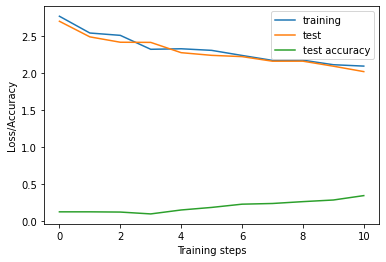

In [ ]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()

As you can see the network has already learned a bit - each run is a bit different, but you should end up somewhere around 30%-45% accuracy here. 

**We want to look into the effect of Mini-Batching and Batch Sizes!**
 - Let's start by creating the *gold standard* - a full batch gradient. We can get this by averaging all gradients over all dataset elements: 
 - Notice we look into how different gradients are for different batch sizes for each layer individually here! We could also just concatenate them instead and look at the similarities between the global gradient vectors that we get from different batch sizes. 

We start by creating a function that will replace the train step in loop just like the training loop above. But instead of applying gradients and training that way, we **will not apply the respective gradients and instead return them for further inspection** 

In [ ]:
def calculate_gradients(model, input, target, loss_function, batch_size):
    #just like train step, but don't apply gradients:
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

We can apply this to every training sample and average over all the results to get the full batch gradient:

In [ ]:
#notice that while we batch here, we average over all samples from ALL BATCHES, so the batch_size does not have an effect here!
gradient_aggregator = [[] for _ in model.trainable_variables]

cross_entropy_loss_no_reduction = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
for input,target in train_dataset.batch(32):
    gradients = calculate_gradients(model, input, target, cross_entropy_loss_no_reduction, optimizer)
    for gradient, agg in zip(gradients, gradient_aggregator):
        agg.append(gradient)

#In this variable we can store the full batch gradients:
FULL_BATCH_GRADIENTS = []

#iterate over gradients of all the different weight vectors!
for gradients in gradient_aggregator:
    #first we just stack the respective gradients along the first ('batch') axis
    gradients = tf.stack(gradients, axis=0)
    #With all gradients extracted, we need to average them! (along this 'batch' axis)
    gradients = tf.reduce_mean(gradients, axis=0)
    #Now we just need to reshape these into vectors
    gradients = tf.reshape(gradients, (-1,))
    FULL_BATCH_GRADIENTS.append(gradients)


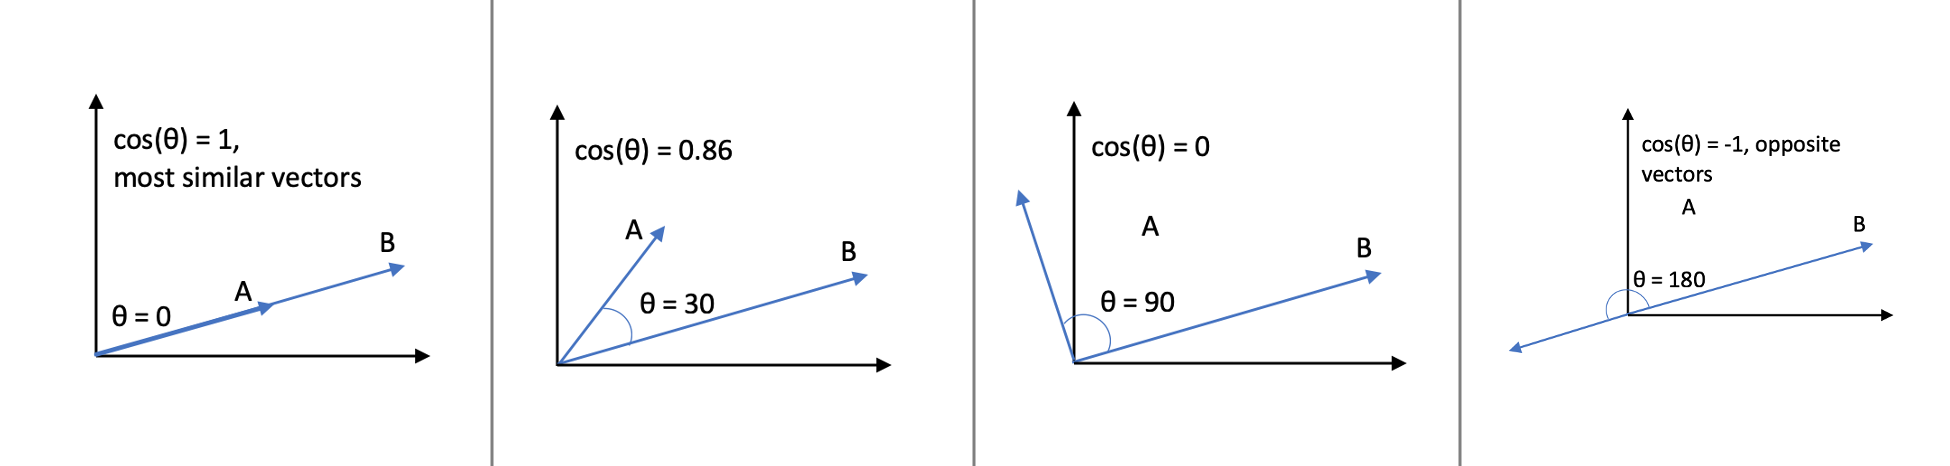
from https://towardsdatascience.com/cosine-similarity-how-does-it-measure-the-similarity-maths-behind-and-usage-in-python-50ad30aad7db


We use Cosine Similarity to see how similar gradients from different batch sizes actually are to the full batch gradient. Cosine Similarity effectively describes the angle between the two gradient vectors, it is larger for more similar vectors! It is commonly used for comparing high-dimensional vectors.

In [ ]:
cross_entropy_loss_no_reduction = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

cosine_similarity = tf.keras.losses.CosineSimilarity(reduction=tf.keras.losses.Reduction.NONE)

BATCH_SIZES = [1,2,4,8,16,32,64,128,256,512, 1024, 2048]

similarity_results = []

#for each batch size
for batch_size in BATCH_SIZES:
    print(batch_size)
    batch_size_aggregator = [[] for _ in model.trainable_variables]
    #check all the gradients
    #just check up to one thousand gradients for each or this takes hours!
    for input,target in train_dataset.batch(batch_size).take(1000):
        gradients = calculate_gradients(model, input, target, cross_entropy_loss_no_reduction, optimizer)

        for batch_size_gradient, full_batch_gradient, aggregator in zip(gradients, FULL_BATCH_GRADIENTS, batch_size_aggregator):
            #notice we use negative cosine similarity because it is used as a loss in tf (a loss is minimized, simiarlity is maximised, so tf internally uses the negative similarity as the loss!)
            #for each gradient check how similar it is to 
            batch_size_gradient = tf.reshape(batch_size_gradient, (-1,))
            similarity = -cosine_similarity(full_batch_gradient, batch_size_gradient)
            aggregator.append(similarity)

    #finaly average the respective similarities for all 6 different weights!
    similarities = [tf.reduce_mean(aggregator) for aggregator in batch_size_aggregator]
    similarity_results.append(similarities)


1
2
4
8
16
32
64
128
256
512
1024
2048


We now have the similarities of gradients of each batch size to the full batch gradients for each weight vector/matrix!
Let's visualize this:

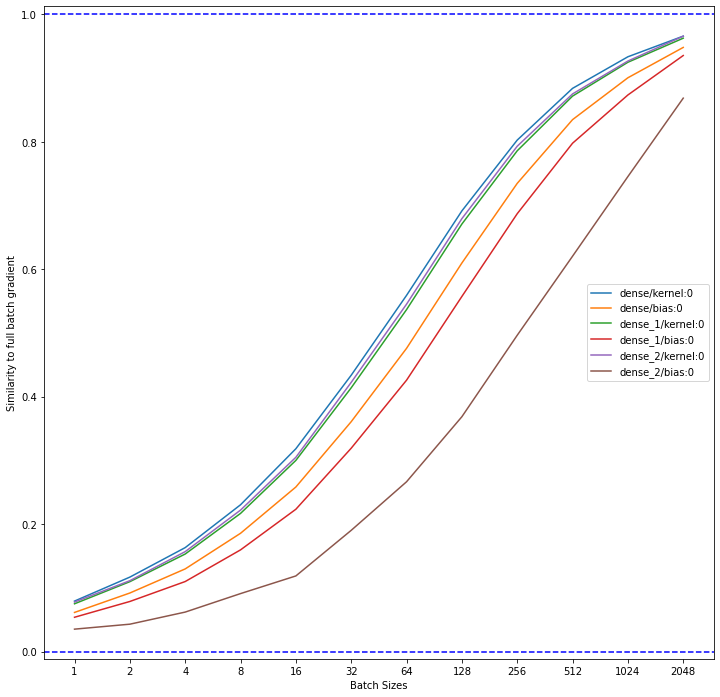

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
lines = []
for i, variable in enumerate(model.trainable_variables):
    similarities = [result[i] for result in similarity_results]
    line, = plt.plot(similarities)
    lines.append(line)
batch_names = [str(batch_size) for batch_size in BATCH_SIZES]
plt.axhline(y=1.0, color='b', linestyle='dashed', label='max cosine similarity')
plt.axhline(y=-0.0, color='b', linestyle='dashed', label='min cosine similarity')
plt.xticks(np.arange(len(BATCH_SIZES)), batch_names)
plt.xlabel("Batch Sizes")
plt.ylabel("Similarity to full batch gradient")
plt.legend(lines, [var.name for var in model.trainable_variables])
plt.show()

